In [ ]:
%pip install numpy pandas seaborn matplotlib scikit-learn xgboost tensorflow


In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import xgboost as xgb
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

import time

import warnings
warnings.filterwarnings(action="ignore")

In [5]:
# Loading all the dataset
orders = pd.read_csv('orders.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

In [6]:
orders.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
order_products_prior.head()


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [8]:
order_products_train.head()


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [9]:
products.head()


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [10]:
aisles.head()


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [11]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [12]:
# Merge datasets
df = pd.concat( [ order_products_train , order_products_prior ])

print("before merge" , df.shape)

df = pd.merge(df, products, on='product_id', how='left')
df = pd.merge(df, aisles, on='aisle_id', how='left')
df = pd.merge(df, departments, on='department_id', how='left')
df = pd.merge(df, orders, on='order_id', how='left')

print("after merge" , df.shape)

before merge (33819106, 4)
after merge (33819106, 15)


In [13]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9.0
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   product_id              int64  
 2   add_to_cart_order       int64  
 3   reordered               int64  
 4   product_name            object 
 5   aisle_id                int64  
 6   department_id           int64  
 7   aisle                   object 
 8   department              object 
 9   user_id                 int64  
 10  eval_set                object 
 11  order_number            int64  
 12  order_dow               int64  
 13  order_hour_of_day       int64  
 14  days_since_prior_order  float64
dtypes: float64(1), int64(10), object(4)
memory usage: 3.8+ GB


# Handling Missing Values

In [15]:
def fillna(df):
    numerical_features = df.select_dtypes(include=[np.number]).columns
    df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median())
    categorical_features = df.select_dtypes(exclude=[np.number]).columns
    for col in categorical_features:
        df[col] = df[col].fillna(df[col].mode()[0])

def replace_inf(df):
    numerical_features = df.select_dtypes(include=[np.number]).columns
    df[numerical_features] = df[numerical_features].replace([np.inf, -np.inf], np.nan)
    df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median())


replace_inf(df)
fillna(df)

# Exploratory Data Analysis

### Aisle Most Favored by Customers

In [16]:
df_by_aisle = df.groupby('aisle')["reordered"].aggregate(['count', 'sum']).rename(columns={'count': 'total_orders', 'sum': 'reordered_count'})

df_by_aisle = df_by_aisle.sort_values('total_orders', ascending=False).reset_index()

df_by_aisle[:5]

,aisle,total_orders,reordered_count
0,fresh fruits,3792661,2726251
1,fresh vegetables,3568630,2123540
2,packaged vegetables fruits,1843806,1178700
3,yogurt,1507583,1034957
4,packaged cheese,1021462,598280


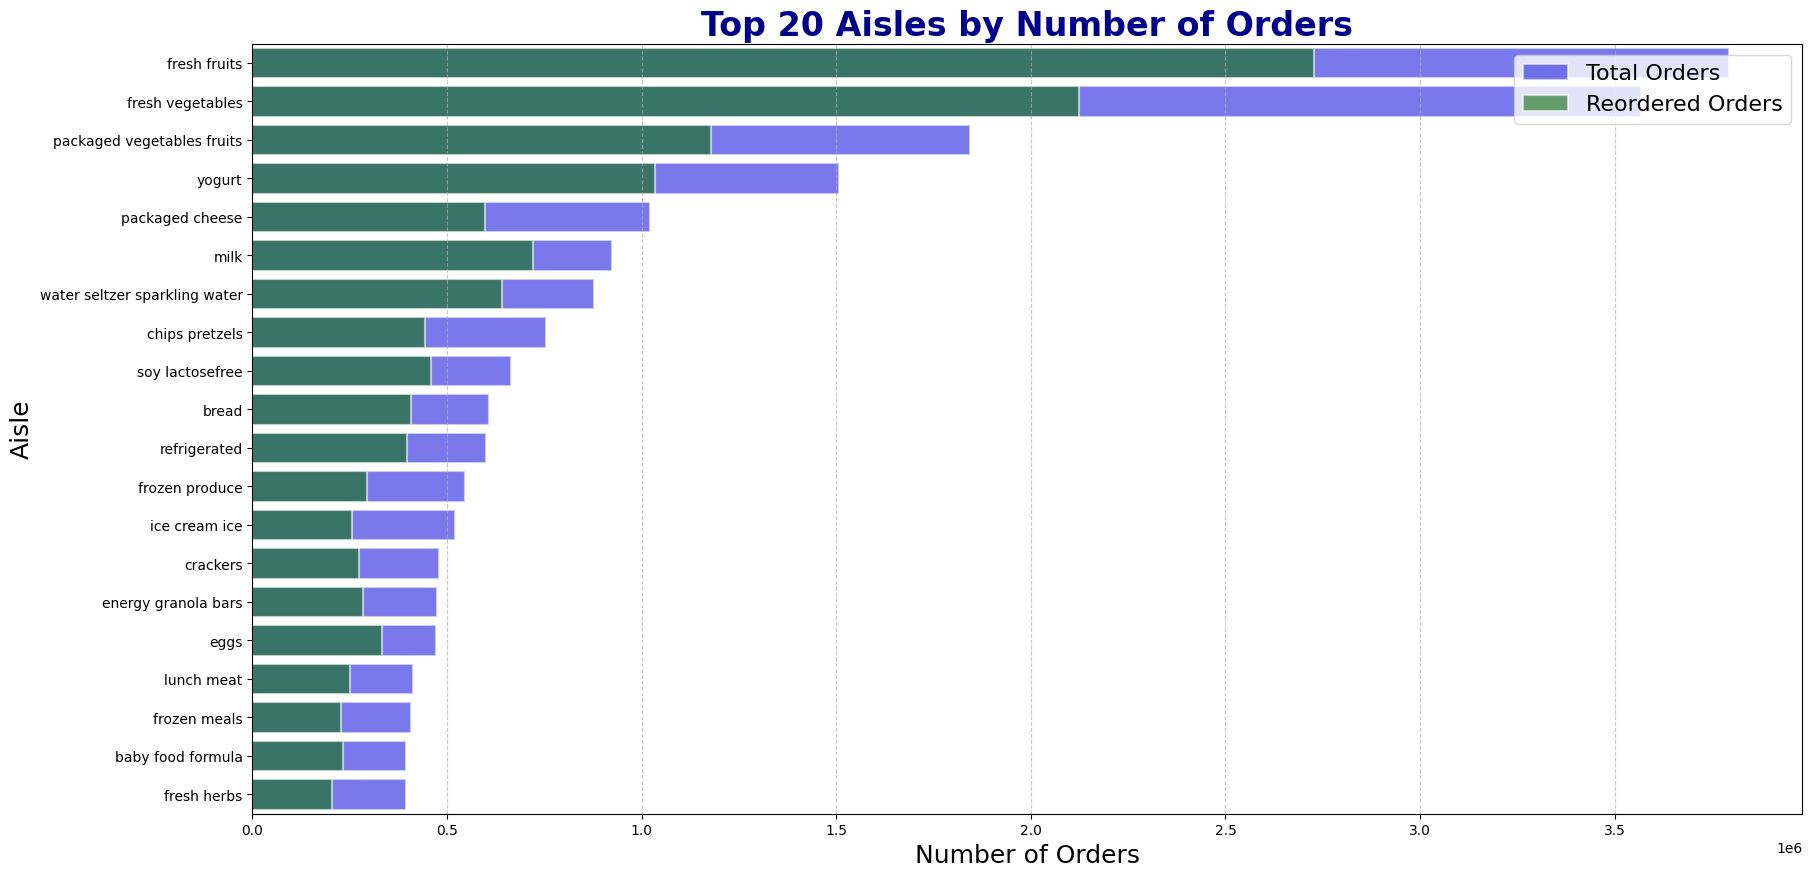

In [ ]:
fig, axis = plt.subplots(figsize=(20, 10))
axis.set_title("Top 20 Aisles by Number of Orders", fontsize=24, fontweight='bold', color='darkblue')


sns.barplot(x='total_orders', y='aisle', data=df_by_aisle[:20], label='Total Orders', color='b', alpha=0.6, edgecolor='w', linewidth=1.5)

sns.barplot(x='reordered_count', y='aisle', data=df_by_aisle[:20], label='Reordered Orders', color='g', alpha=0.6, edgecolor='w', linewidth=1.5)

axis.set_xlabel('Number of Orders', fontsize=18)
axis.set_ylabel('Aisle', fontsize=18)

total_orders = df_by_aisle['total_orders'][:20]
reordered_count = df_by_aisle['reordered_count'][:20]


axis.legend(loc='upper right', fontsize=16)

axis.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


### In which aisle do customers return most frequently?

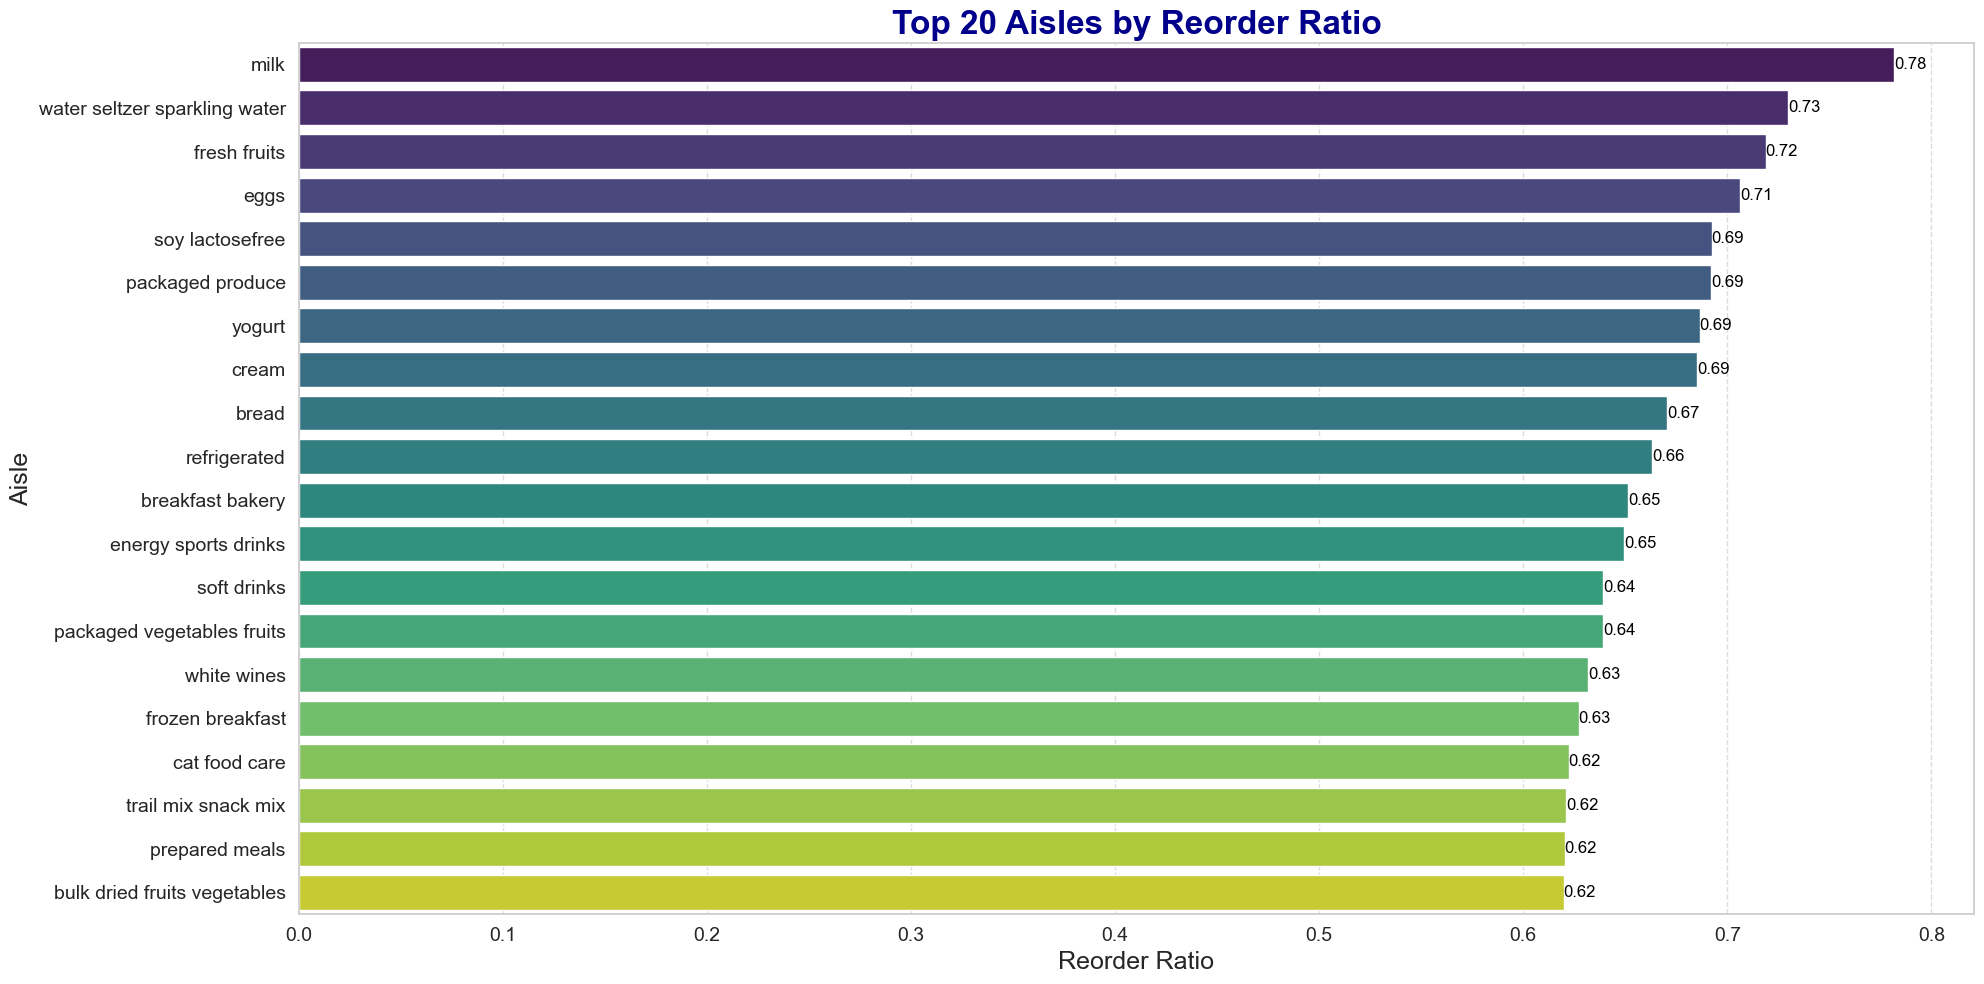

In [ ]:
df_by_aisle['reorder_ratio'] = df_by_aisle['reordered_count'] / df_by_aisle['total_orders']

df_by_aisle = df_by_aisle.sort_values('reorder_ratio', ascending=False).reset_index()

sns.set(style='whitegrid')

fig, axis = plt.subplots(figsize=(20, 10))

axis.set_title("Top 20 Aisles by Reorder Ratio", fontsize=24, fontweight='bold', color='darkblue')


sns.barplot(x='reorder_ratio', y='aisle', data=df_by_aisle[:20], palette='viridis', ax=axis)

axis.set_xlabel('Reorder Ratio', fontsize=18)
axis.set_ylabel('Aisle', fontsize=18)

axis.grid(axis='x', linestyle='--', alpha=0.7)

axis.tick_params(axis='both', labelsize=14)

for p in axis.patches:
    axis.annotate(f'{p.get_width():.2f}', (p.get_width(), p.get_y() + p.get_height() / 2), 
                  ha='left', va='center', fontsize=12, color='black')

plt.tight_layout() 
plt.show()

### Aisles with the Lowest Reorder Ratio

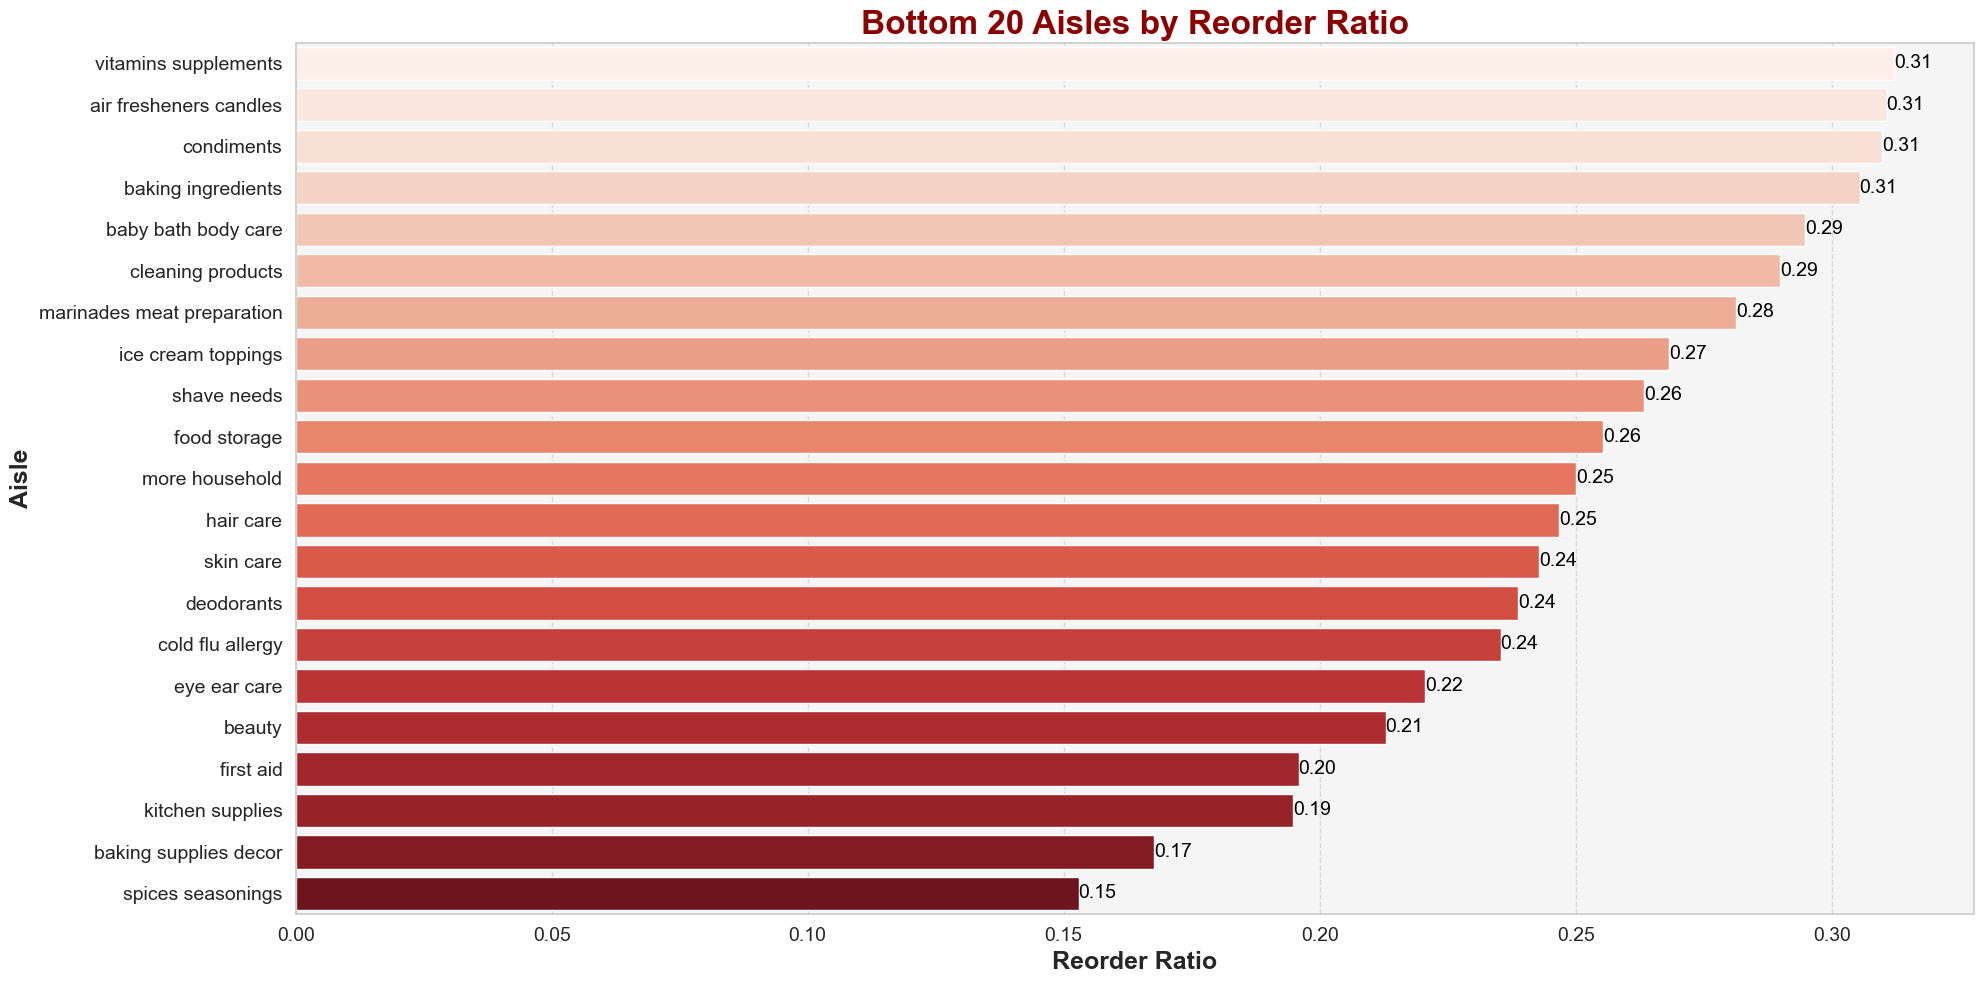

In [ ]:
sns.set_palette("rocket")  

fig, axis = plt.subplots(figsize=(20, 10))


axis.set_title("Bottom 20 Aisles by Reorder Ratio", fontsize=24, fontweight='bold', color='darkred')

sns.barplot(x='reorder_ratio', y='aisle', data=df_by_aisle[-21:], palette='Reds', ax=axis)

axis.xaxis.grid(True, linestyle='--', alpha=0.7)

axis.set_xlabel('Reorder Ratio', fontsize=18, fontweight='bold')
axis.set_ylabel('Aisle', fontsize=18, fontweight='bold')

axis.tick_params(axis='both', labelsize=14)

for index, value in enumerate(df_by_aisle['reorder_ratio'][-21:]):
    axis.text(value, index, f"{value:.2f}", va='center', fontsize=14, color='black')

axis.set_facecolor('#f5f5f5')

plt.tight_layout()
plt.show()


### Departments Most Favored by Customers

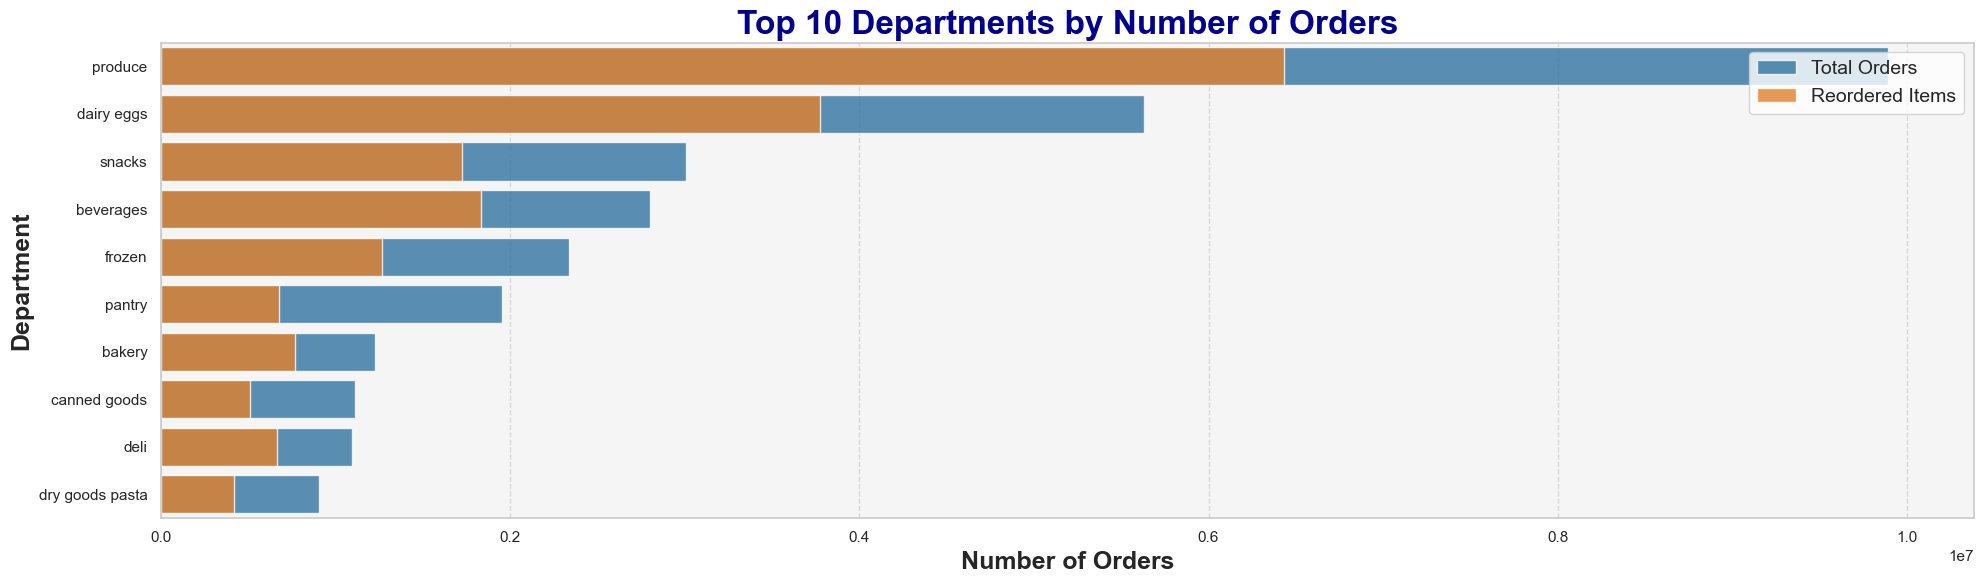

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_by_department = df.groupby('department')['reordered'].aggregate(['count', 'sum']).rename(columns={'count': 'total_orders', 'sum': 'reordered_count'})
df_by_department = df_by_department.sort_values('total_orders', ascending=False).reset_index()

fig, axis = plt.subplots(figsize=(20, 6))

palette = ['#1f77b4', '#ff7f0e']  # Blue and Orange colors

sns.barplot(x='total_orders', y='department', data=df_by_department[:10], color=palette[0], label='Total Orders', ax=axis, alpha=0.8)

sns.barplot(x='reordered_count', y='department', data=df_by_department[:10], color=palette[1], label='Reordered Items', ax=axis, alpha=0.8)

axis.set_title("Top 10 Departments by Number of Orders", fontsize=24, fontweight='bold', color='darkblue')
axis.set_xlabel("Number of Orders", fontsize=18, fontweight='bold')
axis.set_ylabel("Department", fontsize=18, fontweight='bold')

axis.legend(loc='upper right', fontsize=14)

axis.xaxis.grid(True, linestyle='--', alpha=0.7)

axis.set_facecolor('#f5f5f5')

plt.tight_layout()

plt.show()


### In which Department do customers return most frequently?

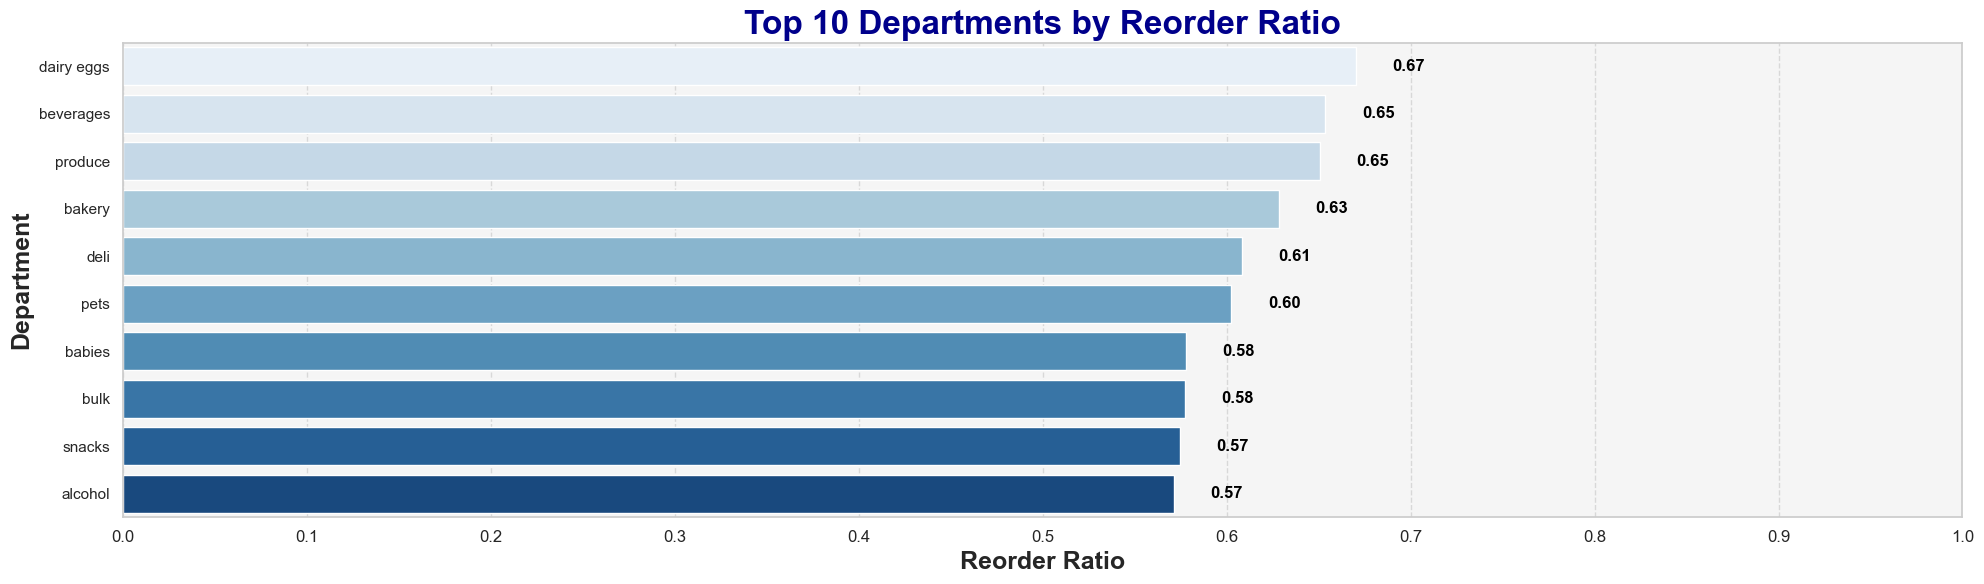

In [ ]:
df_by_department['reorder_ratio'] = df_by_department['reordered_count'] / df_by_department['total_orders']
df_by_department = df_by_department.sort_values('reorder_ratio', ascending=False).reset_index()

fig, axis = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("Blues", n_colors=10)

sns.barplot(x='reorder_ratio', y='department', data=df_by_department[:10], palette=palette, ax=axis)

axis.set_title("Top 10 Departments by Reorder Ratio", fontsize=24, fontweight='bold', color='darkblue')
axis.set_xlabel("Reorder Ratio", fontsize=18, fontweight='bold')
axis.set_ylabel("Department", fontsize=18, fontweight='bold')

axis.xaxis.grid(True, linestyle='--', alpha=0.7)
axis.set_xticks(np.arange(0, 1.1, 0.1))  # Set x-ticks for better readability
axis.set_xticklabels([f'{x:.1f}' for x in np.arange(0, 1.1, 0.1)], fontsize=12)

for index, row in df_by_department[:10].iterrows():
    axis.text(row['reorder_ratio'] + 0.02, index, f"{row['reorder_ratio']:.2f}", 
              va='center', fontsize=12, color='black', fontweight='bold')

axis.set_facecolor('#f5f5f5')

plt.tight_layout()

plt.show()

### Products

### Understanding how customers treat their most popular items

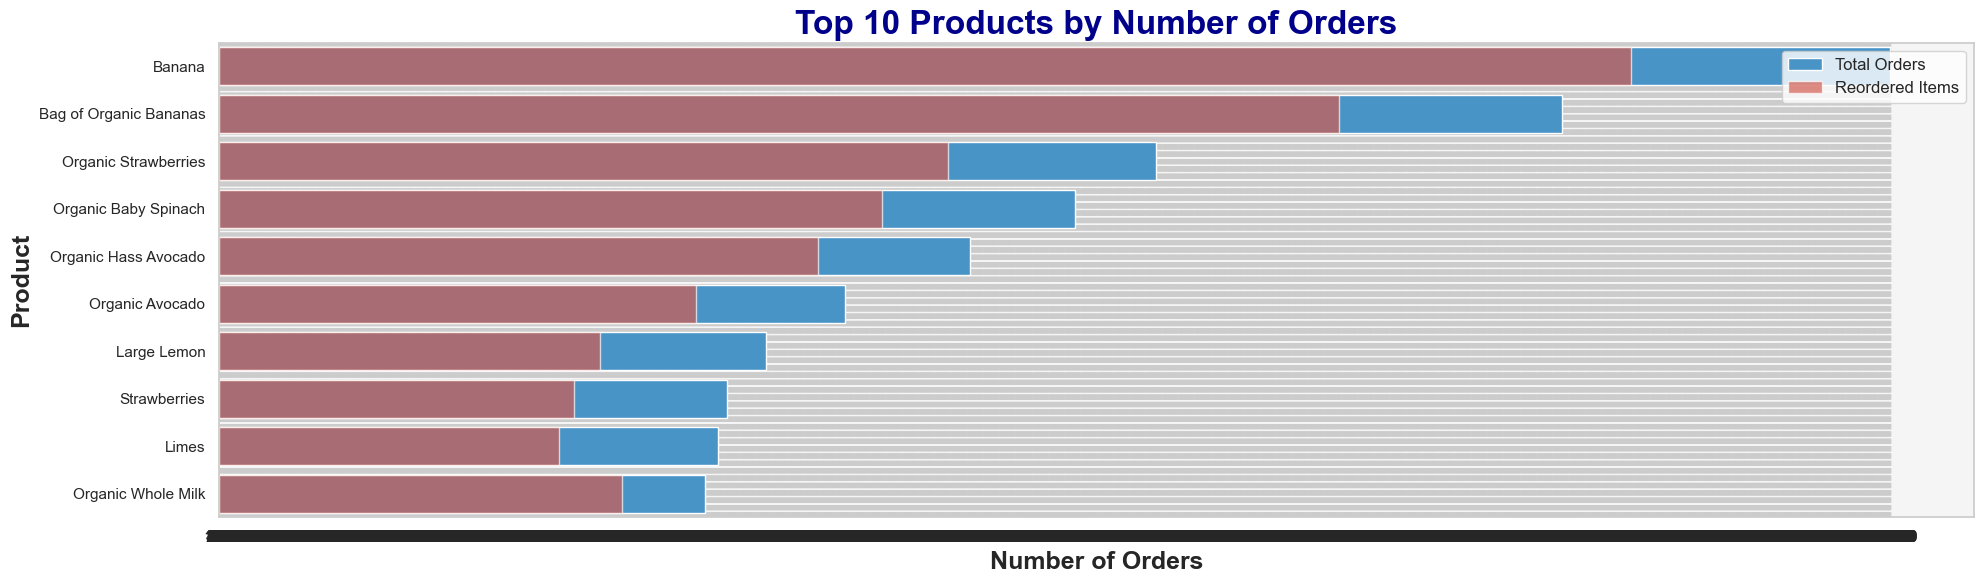

In [ ]:


df_by_product = df.groupby('product_name')['reordered'].aggregate(['count', 'sum']).rename(columns={'count': 'total_orders', 'sum': 'reordered_count'})
df_by_product = df_by_product.sort_values('total_orders', ascending=False).reset_index()

fig, axis = plt.subplots(figsize=(20, 6))

palette = ["#3498db", "#e74c3c"] 

sns.barplot(x='total_orders', y='product_name', data=df_by_product[:10], color=palette[0], label='Total Orders', ax=axis)

sns.barplot(x='reordered_count', y='product_name', data=df_by_product[:10], color=palette[1], label='Reordered Items', ax=axis, alpha=0.7)

axis.set_title("Top 10 Products by Number of Orders", fontsize=24, fontweight='bold', color='darkblue')
axis.set_xlabel("Number of Orders", fontsize=18, fontweight='bold')
axis.set_ylabel("Product", fontsize=18, fontweight='bold')

axis.xaxis.grid(True, linestyle='--', alpha=0.7)
axis.set_xticks(np.arange(0, max(df_by_product['total_orders']) + 50, 100))  # Customize x-ticks
axis.set_xticklabels([str(x) for x in axis.get_xticks()], fontsize=12)

axis.set_facecolor('#f5f5f5')

axis.legend(loc='upper right', fontsize=12)

plt.tight_layout()

plt.show()


### Products with the best Reorder Ratio

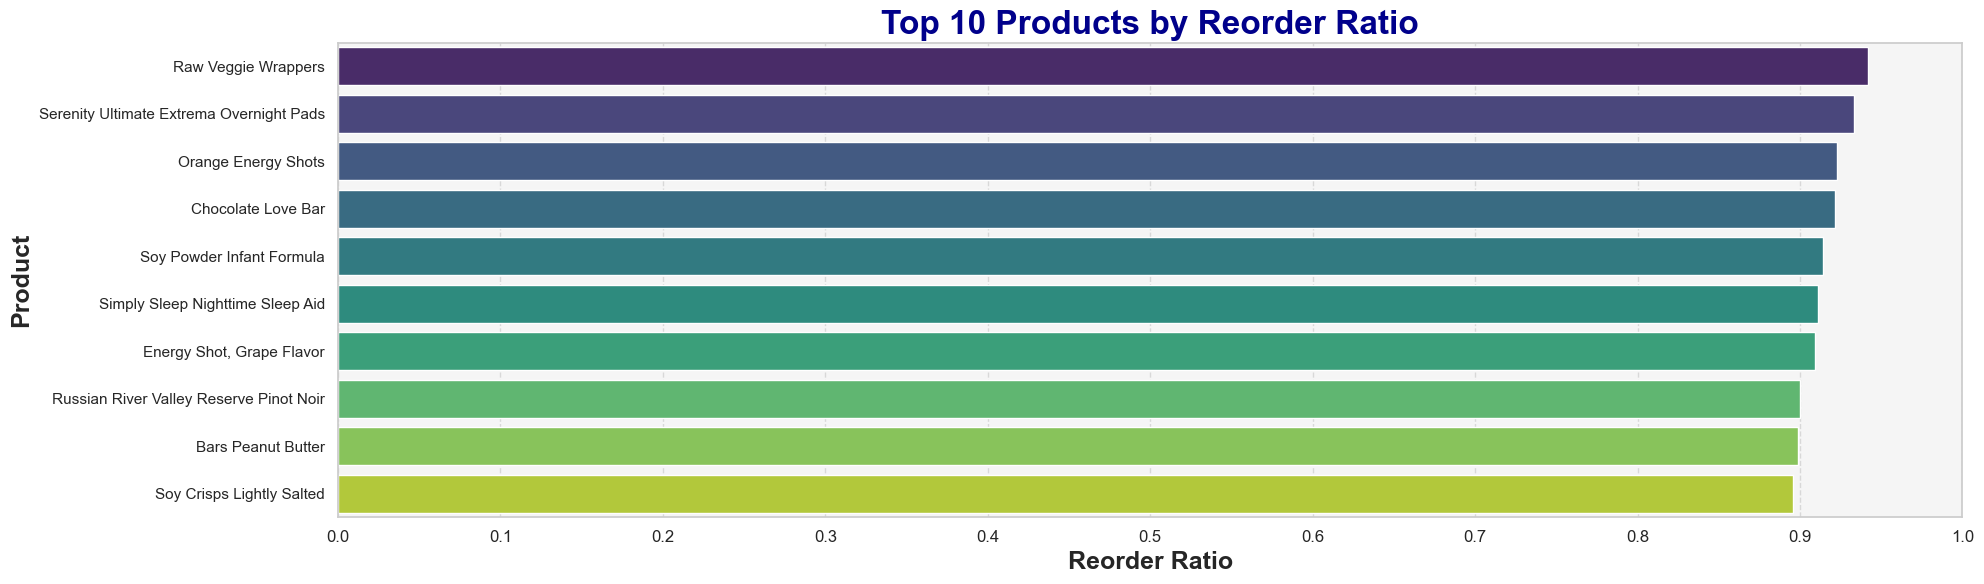

In [ ]:
df_by_product['reorder_ratio'] = df_by_product['reordered_count'] / df_by_product['total_orders']
df_by_product = df_by_product.sort_values('reorder_ratio', ascending=False).reset_index()

fig, axis = plt.subplots(figsize=(20, 6))

palette = sns.color_palette("viridis", n_colors=10) 

sns.barplot(x='reorder_ratio', y='product_name', data=df_by_product[:10], palette=palette, ax=axis)

axis.set_title("Top 10 Products by Reorder Ratio", fontsize=24, fontweight='bold', color='darkblue')
axis.set_xlabel("Reorder Ratio", fontsize=18, fontweight='bold')
axis.set_ylabel("Product", fontsize=18, fontweight='bold')

axis.xaxis.grid(True, linestyle='--', alpha=0.7)
axis.set_xticks(np.arange(0, 1.1, 0.1))  # Adjust x-ticks for better spacing
axis.set_xticklabels([f"{x:.1f}" for x in axis.get_xticks()], fontsize=12)

axis.set_facecolor('#f5f5f5')

plt.tight_layout()

plt.show()


In [24]:
print( "The total number of products that never get reordered: ", df_by_product[df_by_product['reordered_count'] == 0].shape[0])

print( "The percentage of product that dont get reordered: ", f"{df_by_product[df_by_product['reordered_count'] == 0].shape[0] / df_by_product.shape[0] * 100:.2f}%")

The total number of products that never get reordered:  4082
The percentage of product that dont get reordered:  8.22%


## User-level Analysis

### Which products attract the most unique customers?

In [25]:
df_by_product_user  =  df.groupby('product_name')['user_id'].nunique().reset_index().rename(columns={'user_id': 'unique_users'})
df_by_product_user = df_by_product_user.sort_values('unique_users', ascending=False).reset_index(drop=True)
df_by_product_user.head()

,product_name,unique_users
0,Banana,76125
1,Bag of Organic Bananas,65655
2,Organic Strawberries,61129
3,Organic Baby Spinach,56766
4,Large Lemon,48614


### Analyzing the Relationship Between Unique Customers and Total Order

In [27]:
print(df_by_product_user.columns)

df_by_product_user = pd.merge(df_by_product_user, df_by_product, on='product_name', how='left')

print(df_by_product_user.columns)

df_by_product_user =  df_by_product_user.drop(['index_x' ,  'index_y'], axis=1)

df_by_product_user.head()

Index(['product_name', 'unique_users', 'index', 'total_orders',
       'reordered_count', 'reorder_ratio'],
      dtype='object')
Index(['product_name', 'unique_users', 'index_x', 'total_orders_x',
       'reordered_count_x', 'reorder_ratio_x', 'index_y', 'total_orders_y',
       'reordered_count_y', 'reorder_ratio_y'],
      dtype='object')


,product_name,unique_users,total_orders_x,reordered_count_x,reorder_ratio_x,total_orders_y,reordered_count_y,reorder_ratio_y
0,Banana,76125,491291,415166,0.845051,491291,415166,0.845051
1,Bag of Organic Bananas,65655,394930,329275,0.833755,394930,329275,0.833755
2,Organic Strawberries,61129,275577,214448,0.778178,275577,214448,0.778178
3,Organic Baby Spinach,56766,251705,194939,0.774474,251705,194939,0.774474
4,Large Lemon,48614,160792,112178,0.697659,160792,112178,0.697659


### The relationship between the number of unique customers for a product and the total orders it receives.


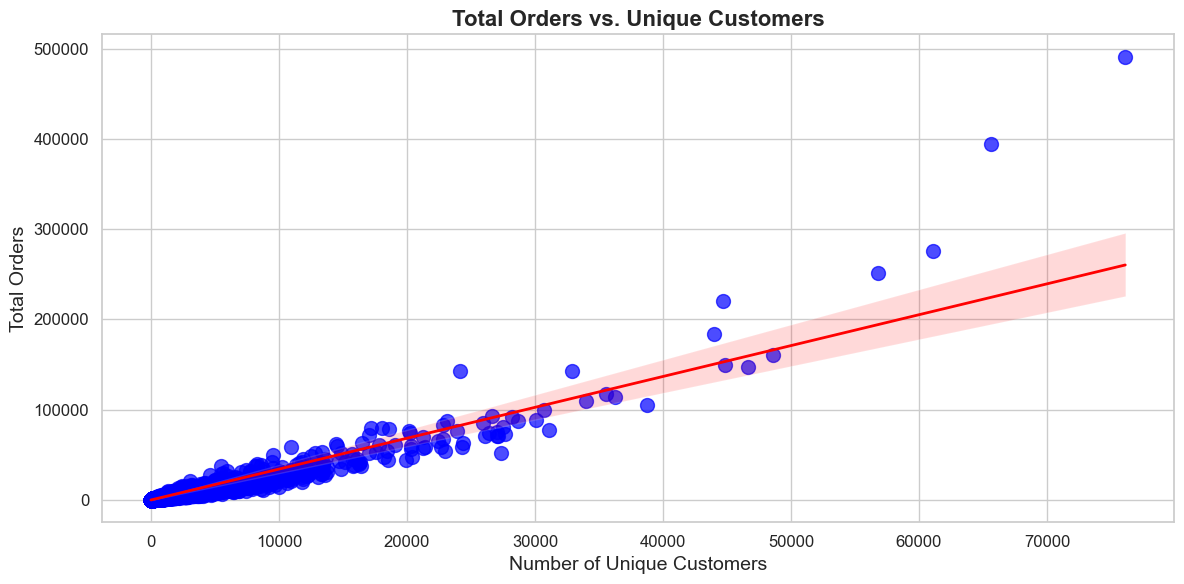

In [ ]:
sns.set(style='whitegrid')

fig, axis = plt.subplots(figsize=(12, 6))

sns.regplot(x='unique_users', y='total_orders_x', data=df_by_product_user,
            scatter_kws={'color': 'blue', 's': 100, 'alpha': 0.7},
            line_kws={'color': 'red', 'lw': 2})

axis.set_title("Total Orders vs. Unique Customers", fontsize=16, fontweight='bold')
axis.set_xlabel("Number of Unique Customers", fontsize=14)
axis.set_ylabel("Total Orders", fontsize=14)

axis.tick_params(axis='both', which='major', labelsize=12)

axis.grid(True)

plt.tight_layout()
plt.show()


The goal is to explore the following aspects of user behavior:
1. Do users tend to reorder products added to their cart earlier or later in their shopping session?
2. What types of products are typically added to the cart at the beginning versus toward the end of the shopping experience?

Text(0, 0.5, 'Reorder Ratio')

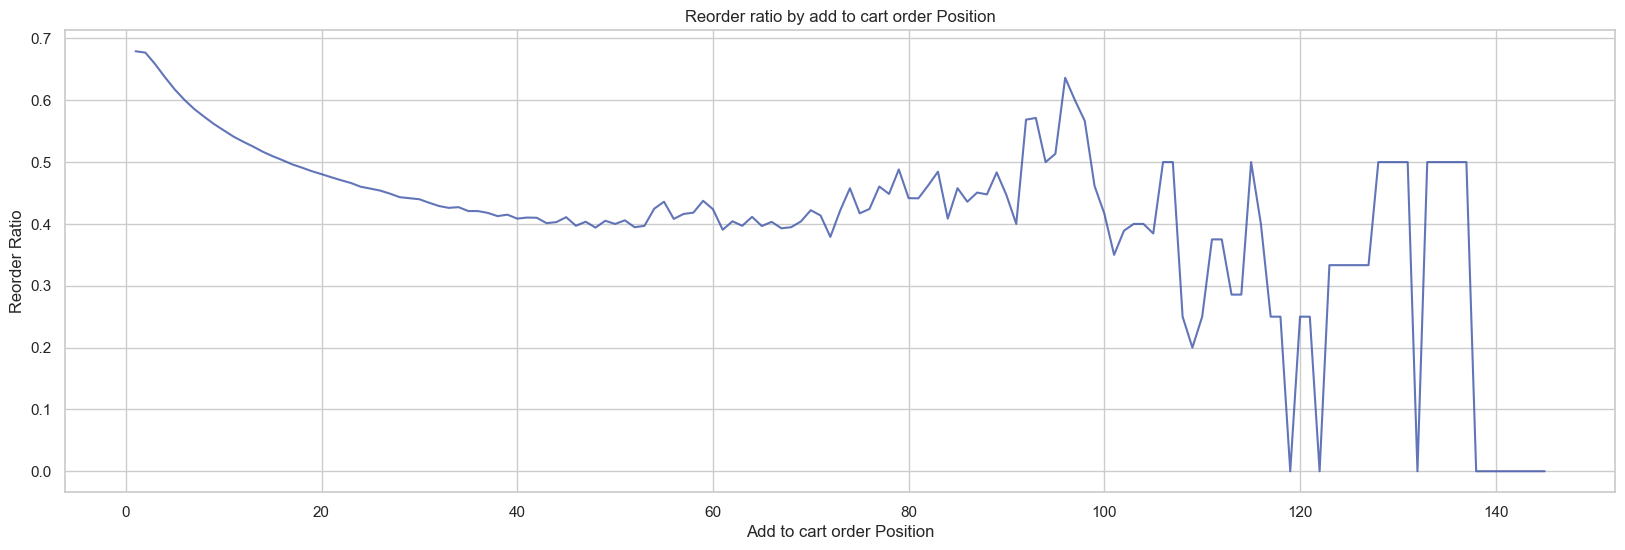

In [30]:
# 1. Impact of the postion on how likely a product is to be reordered.
df_by_reorder = df.groupby('add_to_cart_order')['reordered'].mean().reset_index()

fig , axis = plt.subplots(figsize=(20, 6))

axis = sns.lineplot(x='add_to_cart_order', y='reordered', data=df_by_reorder, color = "#3a53a6" , alpha = 0.8)

axis.set_title("Reorder ratio by add to cart order Position")

axis.set_xlabel("Add to cart order Position")

axis.set_ylabel("Reorder Ratio")

In [31]:
# 2  Products that customers would typically have in their cart very early in the order.
df_by_cart_position = df[df['add_to_cart_order'] <= 10]

df_by_cart_position = (df_by_cart_position.groupby('product_name')['add_to_cart_order']
                       .mean()
                       .reset_index(name='avg_cart_position')
                       .sort_values('avg_cart_position'))

df_by_cart_position.head(10)


,product_name,avg_cart_position
18107,Grain Free Beef & Egg,1.0
17288,Gluten Free Gold Lager,1.0
5616,Bromelain 500mg,1.0
39664,Seltzer Blueberry Lemonade,1.0
11570,Crystal Flakes Sea Salt,1.0
22198,L-Lysine 1000mg Tablets,1.0
30439,Organic Kale Spinach & Apple Greek Yogurt,1.0
44025,Swiss Style Lowfat '1% Chocolate Milk,1.0
42150,Splash Berry Blend,1.0
10561,Cooking Fuel,1.0


### Which Products are in higher demand by the day of the week

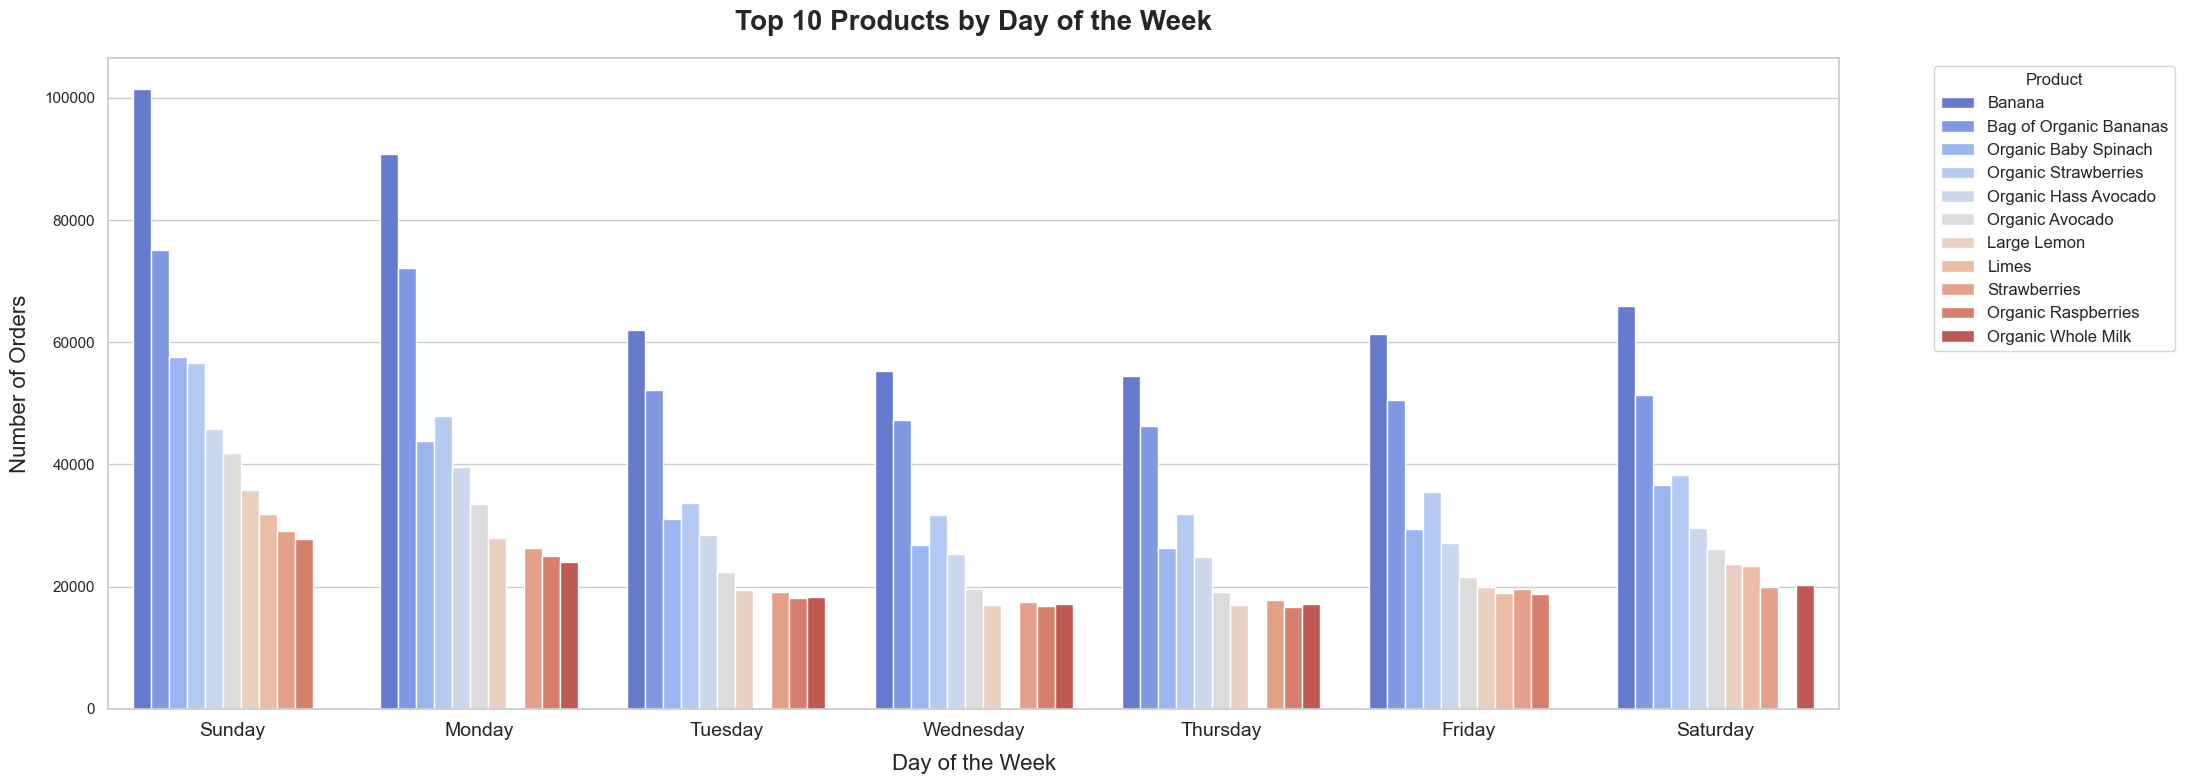

In [ ]:
# Analyze the most popular products by the day of the week
df_by_product_dow = df.groupby(['order_dow', 'product_name']).size().reset_index(name='counts')

# Sort by day of the week and product demand
df_by_product_dow = df_by_product_dow.sort_values(['order_dow', 'counts'], ascending=[True, False])

# Select the top 10 products for each day
df_by_product_dow = df_by_product_dow.groupby('order_dow').head(10).reset_index(drop=True)

# Set up the plot with a larger, more dynamic look
plt.figure(figsize=(22, 8))
sns.set_style("whitegrid")

# Create the barplot
axis = sns.barplot(x='order_dow', y='counts', hue='product_name', data=df_by_product_dow, palette="coolwarm")

axis.set_title("Top 10 Products by Day of the Week", fontsize=20, fontweight='bold', pad=20)
axis.set_xlabel("Day of the Week", fontsize=16, labelpad=10)
axis.set_ylabel("Number of Orders", fontsize=16, labelpad=10)

plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

axis.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], fontsize=14)

plt.tight_layout()
plt.show()


# Feature Engineering

1. Handling Missing Values
    - Numerical Values : Mean imputation
    - Categorial Values : Mode imputation
2. Feature Engineering
    - Frequency of product reorders
    - Time since last purchase (average days)
    - Average add-to-cart position:
    - Top N products, departments, and aisles by orders and reorder ratio

    - Binary indicators for top N
    - Mapping user and product IDs to indices used in CF
3. Dataset reduction (Sampling)

# Data Mining Methods
    - Neural Collaborative Filtering Model (Adam Optimizer)
    - Gradient Boosting
    - Evaluation : F1 Score and Accuracy


In [33]:
import tensorflow as tf
import random 

# Set a seed for reproducibility
def seed_everything(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

In [34]:
# Merge the data
merged_orders = pd.merge(order_products_prior, orders, on='order_id', how='left')
merged_orders = pd.merge(merged_orders, products, on='product_id', how='left')

In [35]:
# Feature Engineering
def feature_engineering(df):
    # Frequency of product reorders
    reorder_frequency = df.groupby(['user_id', 'product_id'])['reordered'].sum().reset_index()
    reorder_frequency.columns = ['user_id', 'product_id', 'reorder_count']
    
    # Time since last purchase
    df['days_since_prior_order'].fillna(0, inplace=True)
    user_last_order = df.groupby('user_id')['days_since_prior_order'].mean().reset_index()
    user_last_order.columns = ['user_id', 'avg_days_since_order']
    
    # Average add-to-cart position
    avg_cart_position = df.groupby('product_id')['add_to_cart_order'].mean().reset_index()
    avg_cart_position.columns = ['product_id', 'avg_cart_position']
    
    return reorder_frequency, user_last_order, avg_cart_position

reorder_freq, user_last_order, avg_cart_pos = feature_engineering(merged_orders)

In [36]:
merged_orders = pd.merge(merged_orders, reorder_freq, on=['user_id', 'product_id'], how='left')
merged_orders = pd.merge(merged_orders, user_last_order, on='user_id', how='left')
merged_orders = pd.merge(merged_orders, avg_cart_pos, on='product_id', how='left')



replace_inf(merged_orders)
fillna(merged_orders)

In [37]:
# Define top N variable
top_n = 10  # You can change this value as needed

# Extract top N Products, Departments, Aisles by number of orders and reorder ratio
top_products_orders = order_products_prior['product_id'].value_counts().nlargest(top_n).index.tolist()
top_products_reorder_ratio = order_products_prior.groupby('product_id')['reordered'].mean().nlargest(top_n).index.tolist()
top_departments_orders = merged_orders['department_id'].value_counts().nlargest(top_n).index.tolist()
top_departments_reorder_ratio = merged_orders.groupby('department_id')['reordered'].mean().nlargest(top_n).index.tolist()
top_aisles_orders = merged_orders['aisle_id'].value_counts().nlargest(top_n).index.tolist()
top_aisles_reorder_ratio = merged_orders.groupby('aisle_id')['reordered'].mean().nlargest(top_n).index.tolist()

# Add binary columns indicating if the product/department/aisle belongs to the top N
merged_orders['top_product_orders'] = merged_orders['product_id'].apply(lambda x: 1 if x in top_products_orders else 0)
merged_orders['top_product_reorder_ratio'] = merged_orders['product_id'].apply(lambda x: 1 if x in top_products_reorder_ratio else 0)
merged_orders['top_department_orders'] = merged_orders['department_id'].apply(lambda x: 1 if x in top_departments_orders else 0)
merged_orders['top_department_reorder_ratio'] = merged_orders['department_id'].apply(lambda x: 1 if x in top_departments_reorder_ratio else 0)
merged_orders['top_aisle_orders'] = merged_orders['aisle_id'].apply(lambda x: 1 if x in top_aisles_orders else 0)
merged_orders['top_aisle_reorder_ratio'] = merged_orders['aisle_id'].apply(lambda x: 1 if x in top_aisles_reorder_ratio else 0)

### Preparing data for Boosted Gradient Descent and Neural Network Collaborative Filtering (Adam Optimizer) 
    - Splitting Data Set into Training and Testing Set 
    - Sampling Dataset using Stratified Sampling

In [38]:
user_ids = merged_orders['user_id'].unique()
product_ids = merged_orders['product_id'].unique()
num_users = len(user_ids)
num_products = len(product_ids)

# Map user and product IDs to indices
user_id_to_index = {user_id: index for index, user_id in enumerate(user_ids)}
product_id_to_index = {product_id: index for index, product_id in enumerate(product_ids)}

# Create user and product index columns
merged_orders['user_index'] = merged_orders['user_id'].map(user_id_to_index)
merged_orders['product_index'] = merged_orders['product_id'].map(product_id_to_index)

# Models
    - Model 1 : Boosted Gradient Descent
    - Model 2 : Neural Network Collaborative Filtering (Adam Optimizer)

In [39]:
def create_ncf_model(num_users, num_products):
    user_input = layers.Input(shape=(1,), name='user_input')
    product_input = layers.Input(shape=(1,), name='product_input')
    
    user_embedding = layers.Embedding(input_dim=num_users, output_dim=15)(user_input)
    product_embedding = layers.Embedding(input_dim=num_products, output_dim=15)(product_input)
    
    user_vecs = layers.Flatten()(user_embedding)
    product_vecs = layers.Flatten()(product_embedding)
    
    # Concatenate user and product vectors
    input_vecs = layers.Concatenate()([user_vecs, product_vecs])
    
    # Hidden layers
    hidden = layers.Dense(32, activation='relu')(input_vecs)
    hidden = layers.Dense(32, activation='relu')(hidden)
    hidden = layers.Dense(32,  activation='relu')(hidden)
    hidden = layers.Dense(32,  activation='relu')(hidden)
    output = layers.Dense(1, activation='sigmoid')(hidden)
    
    model = keras.Model(inputs=[user_input, product_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
xgb_accuracies = []
xgb_f1_scores = []
xgb_losses = []
xgb_runtimes = []

ncf_accuracies = []
ncf_f1_scores = []
ncf_losses = []
ncf_runtimes = []

num_runs = 10 

# Run the training and evaluation 10 times
for run in range(num_runs):
    print(f"\nRun {run + 1} of 10")
    seed_everything(42 + run) 

    # Perform stratified sampling based on 'reordered'
    sampled_data, _ = train_test_split(merged_orders, test_size=0.98, stratify=merged_orders['reordered'], random_state=42 + run)

    # Prepare input and output for the models
    X = sampled_data[['user_index', 'product_index', 'top_product_orders', 'top_product_reorder_ratio', 
                      'top_department_orders', 'top_department_reorder_ratio', 
                      'top_aisle_orders', 'top_aisle_reorder_ratio']]
    y = sampled_data['reordered']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 + run)

    # XGBoost training
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    xgb_params = {
        'objective': 'binary:logistic',
        'max_depth': 6,
        'eta': 0.1,
        'eval_metric': 'logloss',
        'nthread': 4,
        'seed': 42 + run
    }

    evals_result = {}
    start_time = time.time()
    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=[(dtest, 'test')],
                          evals_result=evals_result, verbose_eval=False)
    xgb_runtime = time.time() - start_time

   
    
    
    # Predict using the XGBoost model
    y_pred_xgb = xgb_model.predict(dtest)
    y_pred_xgb_binary = np.where(y_pred_xgb > 0.5, 1, 0)

    # Evaluate the XGBoost model
    xgb_f1 = f1_score(y_test, y_pred_xgb_binary)
    xgb_accuracy = accuracy_score(y_test, y_pred_xgb_binary)
    # Capture the loss from the evaluation results (logloss for binary classification)
    xgb_loss = evals_result['test']['logloss'][-1]  # Get the last logloss entry from evaluation results
    
    xgb_runtimes.append(xgb_runtime)
    xgb_accuracies.append(xgb_accuracy)
    xgb_f1_scores.append(xgb_f1)
    xgb_losses.append(float(xgb_loss))

    # NCF Model training
    ncf_model = create_ncf_model(num_users, num_products)
    start_time2 = time.time()
    history = ncf_model.fit([X_train['user_index'], X_train['product_index']], y_train, epochs=2, shuffle=True, batch_size=64, verbose=0)
    ncf_train_time = time.time() - start_time2

    # Predict using NCF model
    y_pred_ncf = ncf_model.predict([X_test['user_index'], X_test['product_index']])
    y_pred_ncf_binary = np.where(y_pred_ncf > 0.5, 1, 0)

    # Evaluate NCF model
    ncf_f1 = f1_score(y_test, y_pred_ncf_binary)
    ncf_accuracy = accuracy_score(y_test, y_pred_ncf_binary)
    ncf_loss = history.history['loss'][-1]  # Get final loss from training history
    
    ncf_runtimes.append(ncf_train_time)
    ncf_accuracies.append(ncf_accuracy)
    ncf_f1_scores.append(ncf_f1)
    ncf_losses.append(ncf_loss)


Run 1 of 10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

Run 2 of 10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

Run 3 of 10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

Run 4 of 10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

Run 5 of 10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

Run 6 of 10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

Run 7 of 10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Run 8 of 10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

Run 9 of 10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

Run 10 of 10
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [43]:
# Visualization of the results
runs = list(range(1, num_runs + 1))

### Model Analysis and Comparison

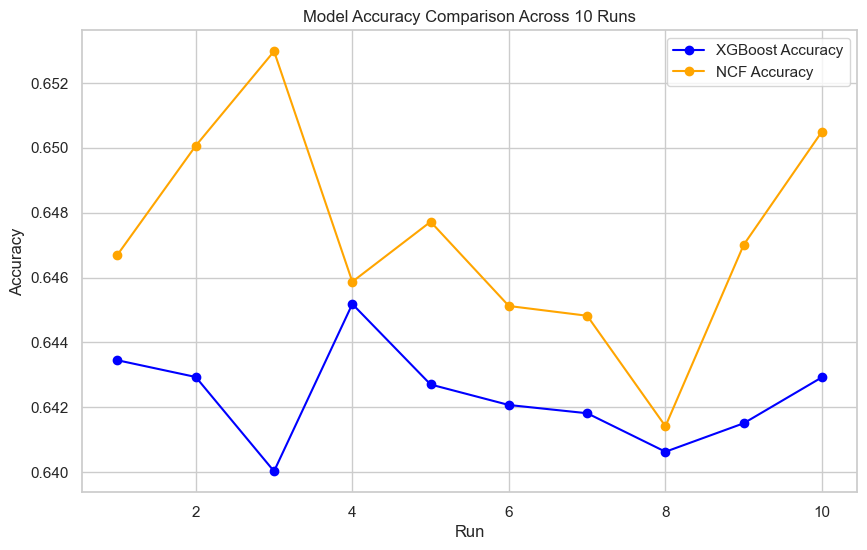

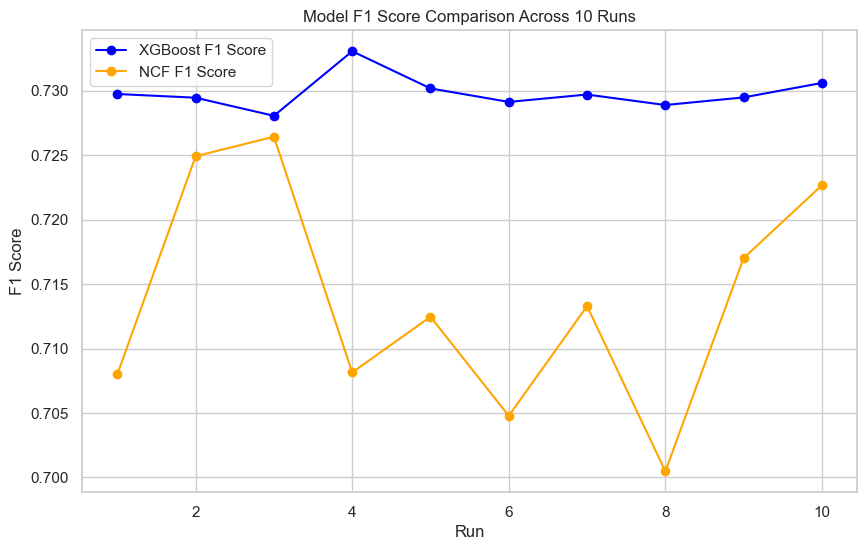

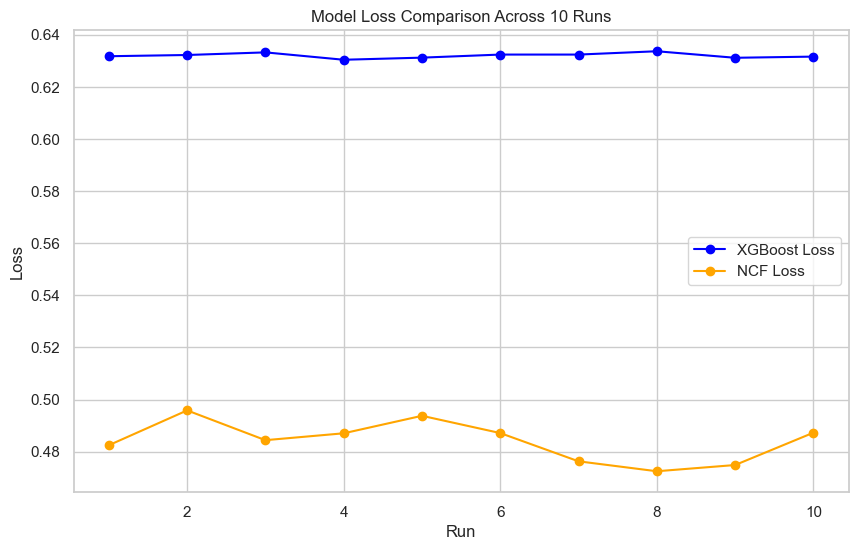

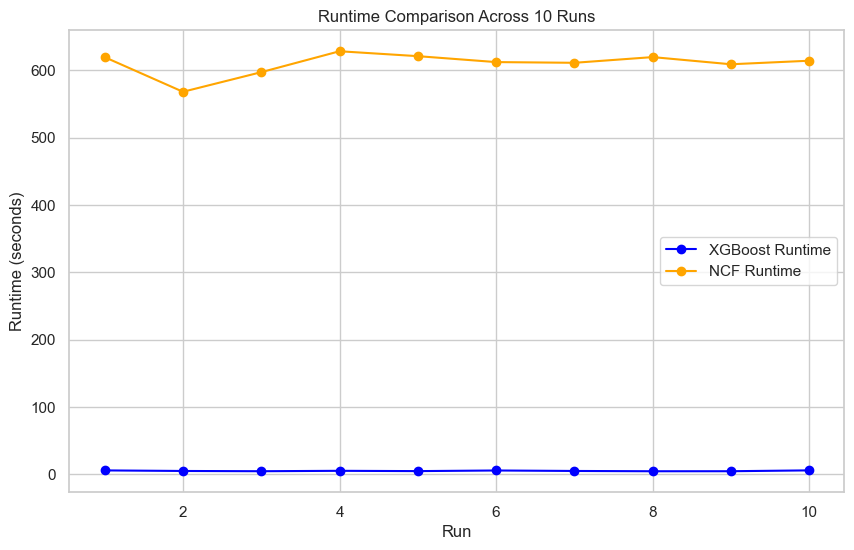


Average Results across Runs:
XGBoost - Avg Accuracy: 0.6423253017620127, Avg F1 Score: 0.729845885664146, Avg Loss: 0.6320514012837866, Avg Runtime: 4.920046782493591 seconds
NCF - Avg Accuracy: 0.6472213229739938, Avg F1 Score: 0.7138253335959612, Avg Loss: 0.4841368407011032, Avg Runtime: 609.9293357610702 seconds


In [44]:
# 1. Accuracy comparison
plt.figure(figsize=(10, 6))
plt.plot(runs, xgb_accuracies, label='XGBoost Accuracy', marker='o', color='blue')
plt.plot(runs, ncf_accuracies, label='NCF Accuracy', marker='o', color='orange')
plt.title('Model Accuracy Comparison Across 10 Runs')
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 2. F1 score comparison
plt.figure(figsize=(10, 6))
plt.plot(runs, xgb_f1_scores, label='XGBoost F1 Score', marker='o', color='blue')
plt.plot(runs, ncf_f1_scores, label='NCF F1 Score', marker='o', color='orange')
plt.title('Model F1 Score Comparison Across 10 Runs')
plt.xlabel('Run')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# 3. Loss comparison
plt.figure(figsize=(10, 6))
plt.plot(runs, xgb_losses, label='XGBoost Loss', marker='o', color='blue')
plt.plot(runs, ncf_losses, label='NCF Loss', marker='o', color='orange')
plt.title('Model Loss Comparison Across 10 Runs')
plt.xlabel('Run')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(runs, xgb_runtimes, label='XGBoost Runtime', marker='o', color='blue')
plt.plot(runs, ncf_runtimes, label='NCF Runtime', marker='o', color='orange')
plt.title('Runtime Comparison Across 10 Runs')
plt.xlabel('Run')
plt.ylabel('Runtime (seconds)')
plt.legend()
plt.show()

# Summary of results
print("\nAverage Results across Runs:")
print(f"XGBoost - Avg Accuracy: {np.mean(xgb_accuracies)}, Avg F1 Score: {np.mean(xgb_f1_scores)}, Avg Loss: {np.mean(xgb_losses)}, Avg Runtime: {np.mean(xgb_runtimes)} seconds")
print(f"NCF - Avg Accuracy: {np.mean(ncf_accuracies)}, Avg F1 Score: {np.mean(ncf_f1_scores)}, Avg Loss: {np.mean(ncf_losses)}, Avg Runtime: {np.mean(ncf_runtimes)} seconds")

In [45]:
# After all runs, create a DataFrame to summarize the results
results_df = pd.DataFrame({
    'Run': [f'Run {i+1}' for i in range(num_runs)],
    'XGBoost Accuracy': xgb_accuracies,
    'XGBoost F1 Score': xgb_f1_scores,
    'XGBoost Runtime (s)': xgb_runtimes,
    'NCF Accuracy': ncf_accuracies,
    'NCF F1 Score': ncf_f1_scores,
    'NCF Runtime (s)': ncf_runtimes
})

# Print the results table
print("\nResults Table:")
print(results_df)


Results Table:
      Run  XGBoost Accuracy  XGBoost F1 Score  XGBoost Runtime (s)  \
0   Run 1          0.643451          0.729760             5.625702   
1   Run 2          0.642934          0.729472             4.789127   
2   Run 3          0.640028          0.728069             4.418302   
3   Run 4          0.645185          0.733079             5.016778   
4   Run 5          0.642703          0.730195             4.585507   
5   Run 6          0.642071          0.729147             5.502551   
6   Run 7          0.641817          0.729719             4.802267   
7   Run 8          0.640630          0.728905             4.373632   
8   Run 9          0.641508          0.729496             4.413945   
9  Run 10          0.642927          0.730619             5.672658   

   NCF Accuracy  NCF F1 Score  NCF Runtime (s)  
0      0.646703      0.708003       619.412425  
1      0.650064      0.724932       567.984933  
2      0.652978      0.726443       597.123355  
3      0.645871  